# Imports

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split


In [49]:
import math
import pprint
import random
from typing import Dict, List, Optional, Set, Tuple, Union

pp = pprint.PrettyPrinter(indent=4)


# Reading data

In [50]:
N_NOTES = -1

def next_n(generator, n: int) -> List[int]:
    return [int(next(generator)) for _ in range(n)]

def read_data(file_name: str) -> List[Tuple[List[int], List[int], List[int]]]:
    sequences = list()
    with open(file_name, "r") as f:
        for line in f:
            values = iter(line.split())
            n_notes = int(next(values))
            sequences.append((next_n(values, n_notes), next_n(values, n_notes - 1), next_n(values, n_notes)))
    global N_NOTES
    N_NOTES = n_notes
    return sequences


In [51]:
sequences = read_data("../data/note_sequences.txt")


# Preparing data

In [52]:
sequences_df = pd.DataFrame(sequences)
sequences_df.head(5)


,0,1,2
0,"[3, 1, 11, 1, 2, 1, 11, 1, 10]","[-2, -2, 2, 1, -1, -2, 2, -3]","[4, 3, 2, 3, 4, 3, 2, 3, 2]"
1,"[5, 11, 4, 0, 4, 1, 7, 8, 6]","[6, 5, -4, -8, -3, -6, 1, -2]","[2, 3, 4, 3, 1, 4, 2, 3, 2]"
2,"[2, 0, 1, 6, 3, 1, 0, 2, 3]","[-2, 1, 5, -3, -2, -1, 2, 1]","[2, 1, 2, 4, 3, 2, 1, 2, 3]"
3,"[7, 5, 2, 5, 9, 3, 7, 4, 11]","[-2, -3, 3, 4, -6, 4, -3, -5]","[3, 2, 1, 2, 3, 2, 3, 2, 1]"
4,"[8, 10, 11, 1, 0, 10, 6, 5, 5]","[2, 1, 2, -1, -2, -4, -1, 0]","[3, 4, 1, 2, 1, 4, 3, 2, 3]"


In [53]:
TARGET_INDEX = 3
PERMUTATION = tuple(range(TARGET_INDEX)) + tuple(range(TARGET_INDEX + 1, N_NOTES)) + (TARGET_INDEX,)


In [54]:
CYCLE_LENGTH = 12

def create_positions_tensor(positions_list: List[List[int]]) -> torch.Tensor:
    positions = np.array(positions_list)[:,PERMUTATION]
    positions = (2 * math.pi / CYCLE_LENGTH) * np.expand_dims(positions, axis=2)
    positions_sin, positions_cos = np.sin(np.copy(positions)), np.cos(np.copy(positions))
    return torch.from_numpy(np.concatenate((positions_sin, positions_cos), axis=2)).float()


In [55]:
MAGNITUDE_SCALE = 12

def create_intervals_tensor(intervals_list: List[List[int]]) -> torch.Tensor:
    # Pad on the left side (set first value to 0 for all sequences)
    intervals = np.pad(np.array(intervals_list), [(0, 0), (1, 0)])
    intervals = intervals[:,PERMUTATION]
    intervals = np.expand_dims(intervals, axis=2)
    intervals_sign, intervals_mag = np.copy(intervals) > 0, np.abs(np.copy(intervals)) / MAGNITUDE_SCALE
    return torch.from_numpy(np.concatenate((intervals_sign, intervals_mag), axis=2)).float()


In [56]:
def create_fingerings_one_hot_tensor(fingerings_list: List[List[int]]) -> torch.Tensor:
    fingerings = np.array(fingerings_list)
    fingerings = np.pad(fingerings[:,:-1], [(0, 0), (1, 0)])[:,PERMUTATION]
    fingerings[:,list(range(TARGET_INDEX, N_NOTES - 1))] = 0
    fingerings_one_hot_tensor = torch.tensor(fingerings)
    return nn.functional.one_hot(fingerings_one_hot_tensor, num_classes=6)


In [57]:
def create_fingerings_tensor(fingerings_list: List[List[int]]) -> torch.Tensor:
    fingerings = np.array(fingerings_list)[:,PERMUTATION]
    return torch.LongTensor(fingerings)


In [58]:
positions_tensor = create_positions_tensor(sequences_df[0].to_list())
intervals_tensor = create_intervals_tensor(sequences_df[1].to_list())
fingerings_one_hot_tensor = create_fingerings_one_hot_tensor(sequences_df[2].to_list())

inputs_tensor = torch.cat((positions_tensor, intervals_tensor, fingerings_one_hot_tensor), dim=2)
outputs_tensor = create_fingerings_tensor(sequences_df[2].to_list())

print(inputs_tensor[:1])
print(outputs_tensor[:1])


tensor([[[ 1.0000e+00,  6.1232e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.0000e-01,  8.6603e-01,  0.0000e+00,  1.6667e-01,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
         [-5.0000e-01,  8.6603e-01,  0.0000e+00,  1.6667e-01,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 8.6603e-01,  5.0000e-01,  1.0000e+00,  8.3333e-02,  1.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.0000e-01,  8.6603e-01,  0.0000e+00,  8.3333e-02,  1.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-5.0000e-01,  8.6603e-01,  0.0000e+00,  1.6667e-01,  1.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.0000e-01,  8.6603e-01,  1.0000e+00,  1.6667e-01,  1.0000e+00,
           0.0000e+

In [59]:
train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(inputs_tensor, outputs_tensor, test_size=0.2)


# Creating GRU model

In [60]:
class Model1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers, drop_prob=0.1):
        super(Model1, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_size, hidden_size, n_layers, dropout=drop_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop_prob)
        self.softmax = nn.LogSoftmax(dim=0)
        
    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        output = self.fc(self.relu(output[-1]))
        output = self.softmax(self.dropout(output))
        return output, hidden
    
    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, self.hidden_size).zero_()
        return hidden


# Training GRU model

In [61]:
gru = Model1(input_size=10, hidden_size=32, output_size=6, n_layers=2)
criterion = nn.NLLLoss()
learning_rate = 0.0001
all_losses = []
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)


def train(input_tensor: torch.Tensor, output_tensor: torch.Tensor) -> Tuple[torch.Tensor, float]:
    hidden = gru.init_hidden()
    optimizer.zero_grad()
    loss = torch.Tensor([0])

    output, hidden = gru(input_tensor, hidden)
    loss += criterion(output, output_tensor[-1])

    loss.backward()
    optimizer.step()

    return output, loss.item() / input_tensor.size(0)


In [62]:
import time
import datetime

n_iters = len(train_inputs) * 1
print_every = int(n_iters // 20)
plot_every = int(n_iters // 100)
total_loss = 0

gru.train()

start = time.time()

for iteration in range(1, n_iters + 1):
    i = random.randint(0, len(train_inputs) - 1)
    input_tensor, output_tensor = train_inputs[i], train_outputs[i]
    output, loss = train(input_tensor, output_tensor)
    total_loss += loss

    if iteration % print_every == 0:
        elapsed_time = datetime.timedelta(seconds=round(time.time() - start))
        print(f"{elapsed_time} ({iteration} {(iteration * 100) // n_iters}%) {round(loss, 4)} {round(all_losses[-1], 5)}")

    if iteration % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


0:00:55 (24000 5%) 0.2001 0.12577
0:01:47 (48000 10%) 0.0253 0.08096
0:02:42 (72000 15%) 0.0132 0.06421
0:03:33 (96000 20%) 0.0036 0.05727
0:04:25 (120000 25%) 0.0141 0.05575
0:05:18 (144000 30%) 0.3333 0.05235
0:06:07 (168000 35%) 0.0965 0.05172
0:06:56 (192000 40%) 0.0453 0.04849
0:07:49 (216000 45%) 0.0039 0.0461
0:08:44 (240000 50%) 0.0023 0.04694
0:09:34 (264000 55%) 0.0652 0.04687
0:10:25 (288000 60%) 0.0059 0.04757
0:11:15 (312000 65%) 0.0206 0.04495
0:12:05 (336000 70%) 0.0009 0.04489
0:12:56 (360000 75%) 0.0026 0.04381
0:13:46 (384000 80%) 0.0968 0.04264
0:14:36 (408000 85%) 0.0007 0.04303
0:15:27 (432000 90%) 0.0062 0.04256
0:16:17 (456000 95%) 0.0835 0.04144
0:17:07 (480000 100%) 0.0022 0.03918


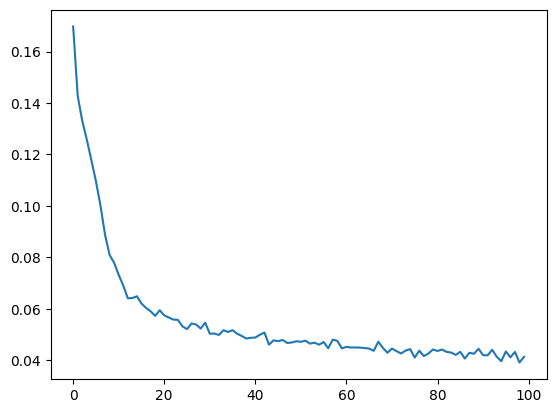

In [63]:
plt.figure()
plt.plot(all_losses)
plt.show()


# Testing GRU model

In [64]:
def validate(gru: nn.Module, inputs: torch.Tensor, outputs: torch.Tensor) -> float:
    gru.eval()
    count = 0

    with torch.no_grad():
        for i in range(len(inputs)):
            input_tensor, output_tensor = inputs[i], outputs[i]
            hidden = gru.init_hidden()

            output, hidden = gru(input_tensor, hidden)

            _, top_i = output.topk(1)
            count += (output_tensor[-1].item() == top_i[0].item())

    return count / len(inputs)


In [65]:
validate(gru, train_inputs, train_outputs)


0.8851916666666667

In [66]:
validate(gru, test_inputs, test_outputs)


0.8842583333333334

# Running on sample data

In [67]:
def evaluate_continuous(gru: nn.Module, positions: torch.Tensor, intervals: torch.Tensor, fingerings: torch.Tensor, window_size: int = N_NOTES):
    fingerings = fingerings[:TARGET_INDEX] + [0] * (N_NOTES - TARGET_INDEX)
    gru.eval()

    with torch.no_grad():
        for i in range(len(positions) - window_size + 1):
            position_tensor = create_positions_tensor([positions[i: i + window_size]])
            interval_tensor = create_intervals_tensor([intervals[i: i + window_size - 1]])
        
            fingering_one_hot_tensor = create_fingerings_one_hot_tensor([fingerings[i: i + window_size]])

            input_tensor = torch.cat((position_tensor, interval_tensor, fingering_one_hot_tensor), dim=2)[0]
            hidden = gru.init_hidden()

            output, hidden = gru(input_tensor, hidden)

            _, top_i = output.topk(1)
            fingerings[i + TARGET_INDEX] = top_i[0].item()
            fingerings.append(0)

    return fingerings[:-1]


In [72]:
DATA_1 = (
    [0] * TARGET_INDEX + [8, 0, 2, 3, 5, 2, 7, 10, 0, 2, 3, 0, 5, 7, 8, 10, 0, 8] + [0] * (N_NOTES - TARGET_INDEX - 1),
    [0] * TARGET_INDEX + [-8, 2, 1, 2, -3, 5, -9, 2, 2, 1, -3, 5, -10, 1, 2, 2, -4] + [0] * (N_NOTES - TARGET_INDEX - 1),
    [0] * TARGET_INDEX,
)
DATA_2 = (
    [0] * TARGET_INDEX + [6, 0, 11, 2, 5, 3, 6, 7, 11, 8, 0, 2, 5, 3, 6, 7, 11] + [0] * (N_NOTES - TARGET_INDEX - 1),
    [0] * TARGET_INDEX + [6, -1, 3, 3, -2, 3, 1, 4, -3, 4, 2, 3, -2, 3, 2, 4] + [0] * (N_NOTES - TARGET_INDEX - 1),
    [0] * TARGET_INDEX,
)
DATA_3 = (
    [0] * TARGET_INDEX + [0, 5, 8, 0, 1, 5, 8, 1, 11, 5, 8, 11, 0, 5, 8, 0] + [0] * (N_NOTES - TARGET_INDEX - 1),
    [0] * TARGET_INDEX + [5, 3, 4, -11, 4, 3, 5, -14, 6, 3, 3, -11, 5, 3, 4] + [0] * (N_NOTES - TARGET_INDEX - 1),
    [0] * TARGET_INDEX,
)
DATA_4 = (
    [0] * TARGET_INDEX + [6, 8, 10, 0, 1, 3, 4, 6, 8, 10, 8, 6, 4, 3, 1, 0, 8, 5] + [0] * (N_NOTES - TARGET_INDEX - 1),
    [0] * TARGET_INDEX + [2, 2, 2, 1, 2, 1, 2, 2, 2, -2, -2, -2, -1, -2, -1, -4, -3] + [0] * (N_NOTES - TARGET_INDEX - 1),
    [0] * TARGET_INDEX,
)
DATA_5 = (
    [0] * TARGET_INDEX + [1, 1, 4, 8, 1, 11, 4, 11, 4, 1, 10, 1, 6, 9, 8, 11, 9, 1, 6, 3] + [0] * (N_NOTES - TARGET_INDEX - 1),
    [0] * TARGET_INDEX + [12, -9, 4, -7, 10, -7, -5, 5, -3, -3, 3, 5, -9, 11, -9, 10, -8, 5, -3] + [0] * (N_NOTES - TARGET_INDEX - 1),
    [0] * TARGET_INDEX,
)

print(evaluate_continuous(gru, *DATA_5))


[0, 0, 0, 4, 5, 1, 5, 1, 5, 2, 1, 2, 1, 4, 5, 5, 1, 5, 1, 5, 1, 2, 1, 0, 0, 0, 0, 0]


# Saving GRU model

In [73]:
torch.save(gru.state_dict(), "model_gru_len9_2-32[2].pt")
